In [1]:
from datasets import load_dataset
from fim.utils.interpolator import FuncInterpolator
import torch
from matplotlib import pyplot as plt
from functools import partial

In [2]:
data = load_dataset("FIM4Science/hawkes-synthetic-short-scale-single-process", "train_process_8")
data.set_format(type='torch')

In [3]:
marks = data['train'][0]['target_kernel_evaluations'].size(0)

# Intensity calculation

$ \hat{\lambda}_k(t) = \text{ReLU}\left( \hat{\lambda}^0_k + \sum_{i: t_{ki} < t} \hat{K}_k(t - t_{ki})\right)$  

In [4]:
data['train'][1940]['target_intensities'].shape

torch.Size([1, 959])

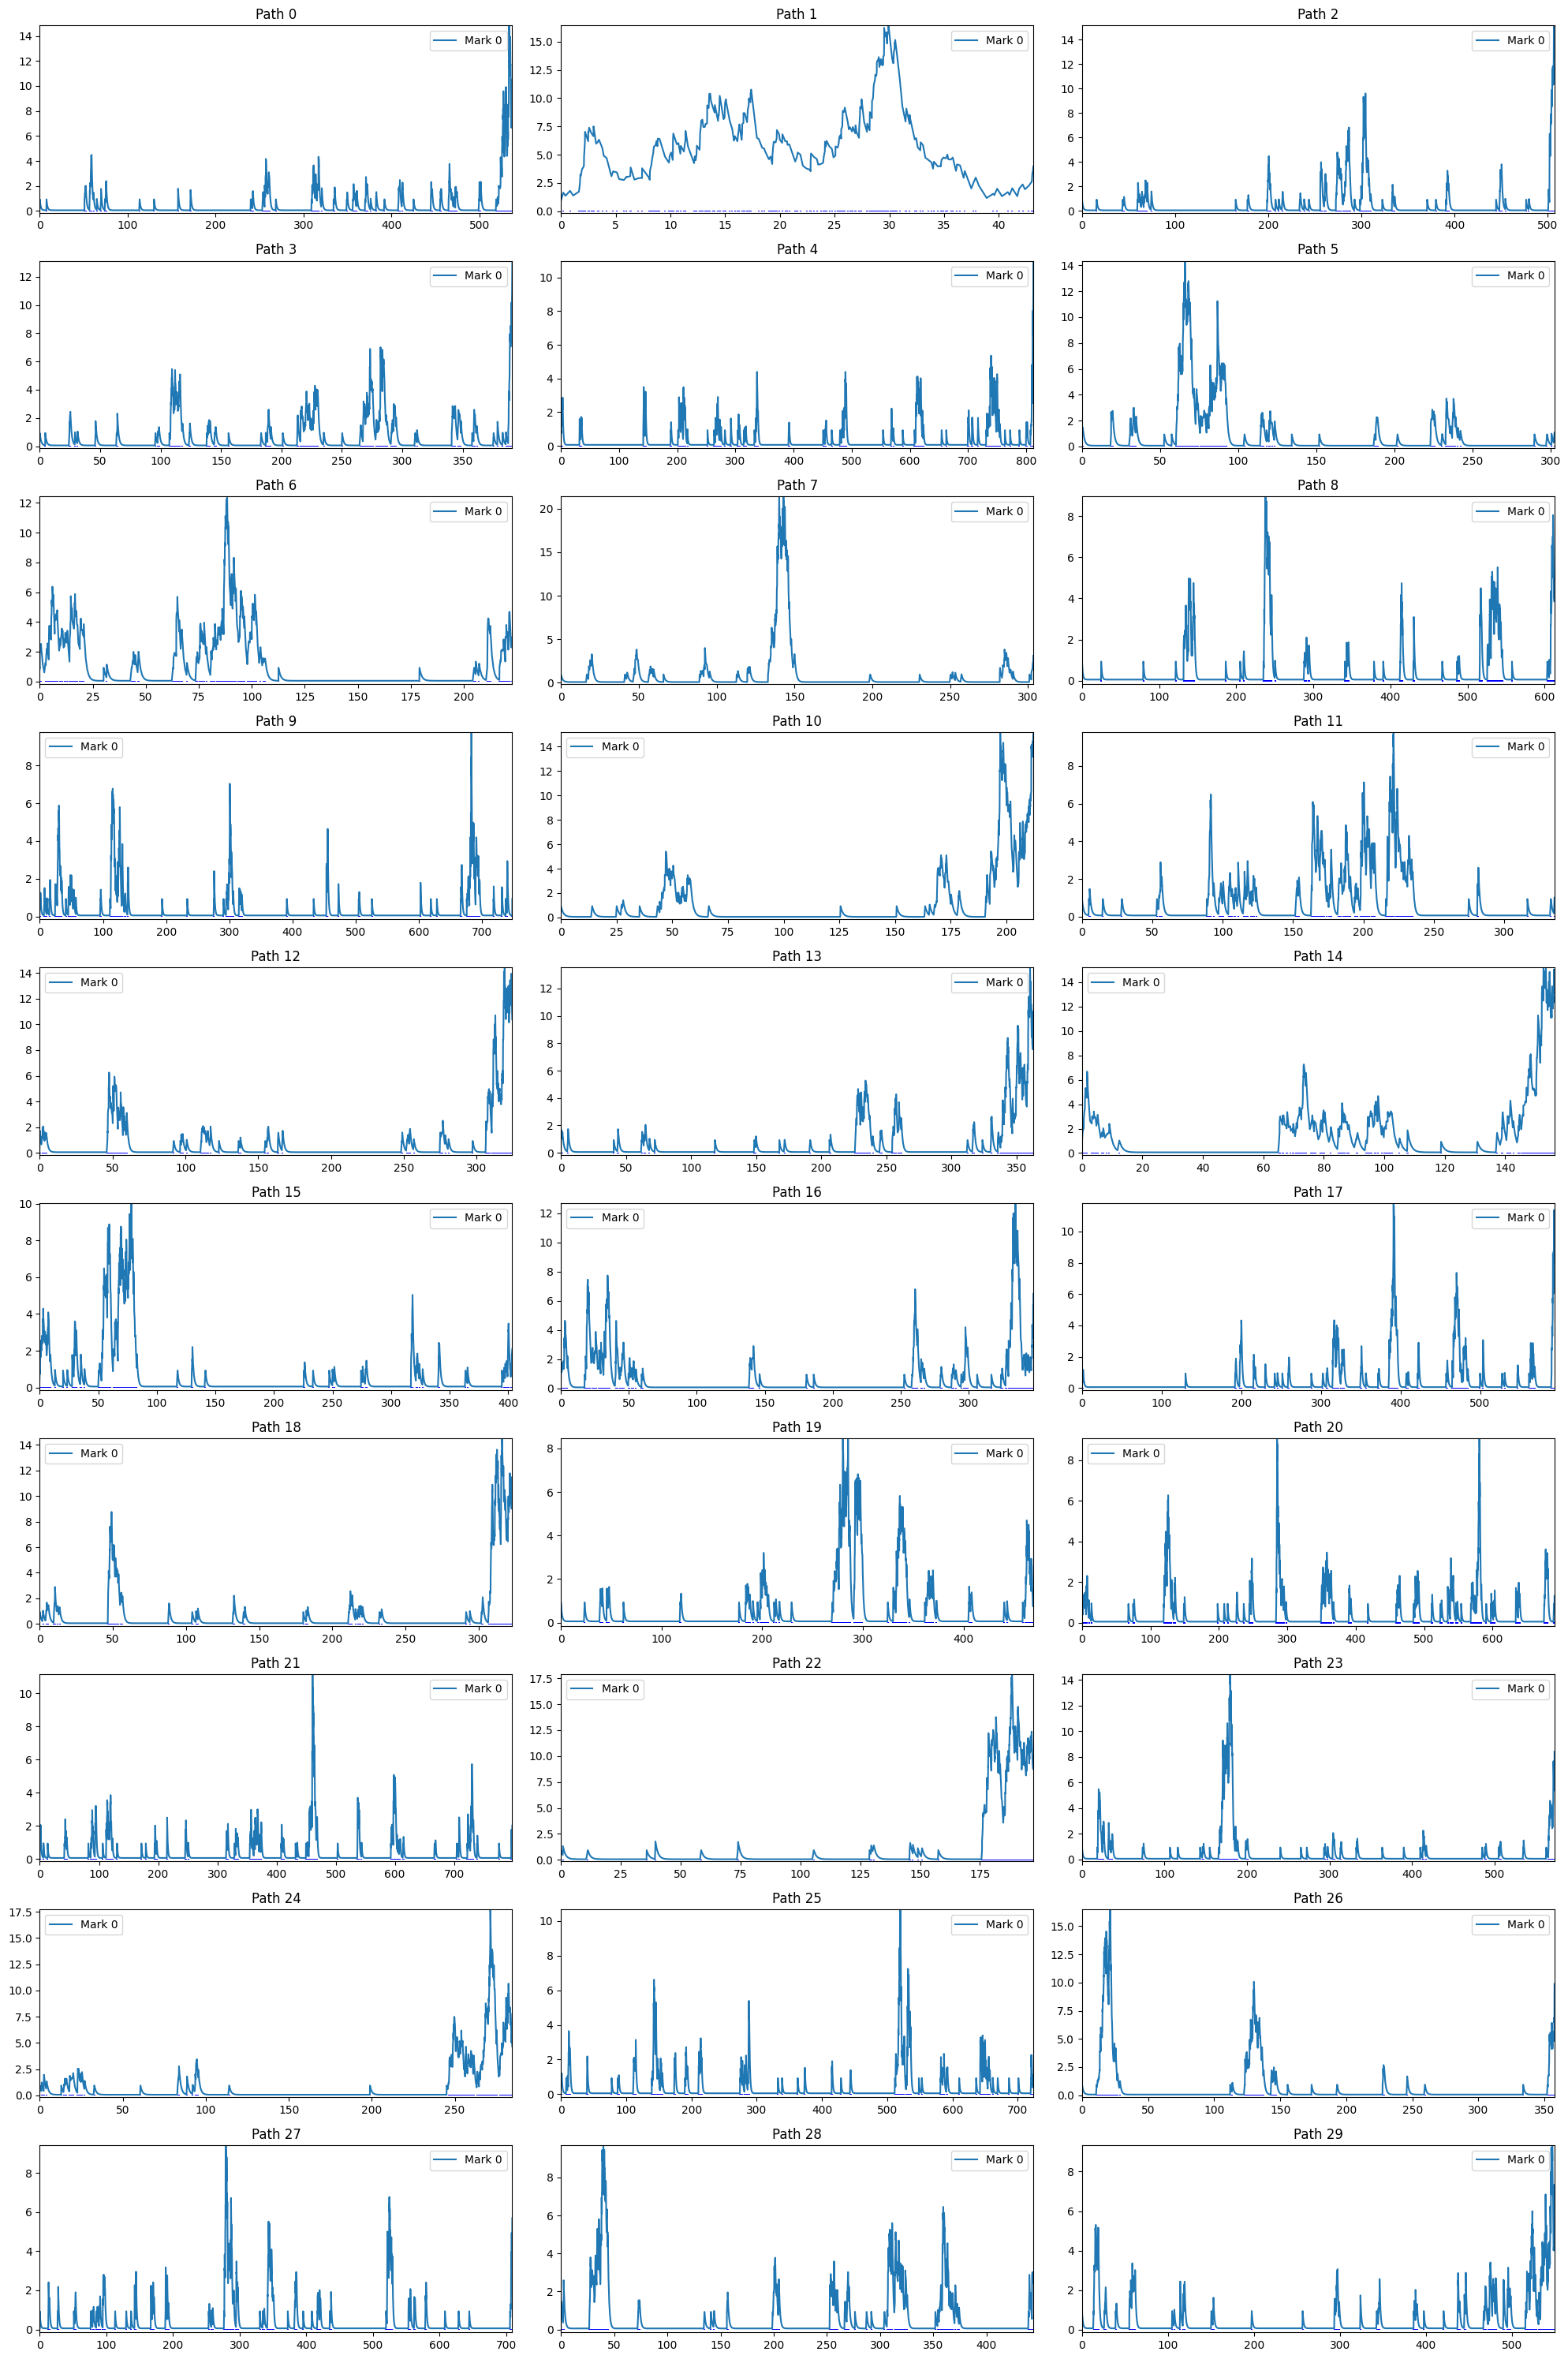

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 3, figsize=(20, 30))
axes = axes.flatten()

for i in range(30):
    time_intensities = data['train'][i]['target_intensity_times']
    intensities = data['train'][i]['target_intensities']

    for mark in range(marks):
        # Plot intensities
        # Plot events
        event_times = data['train'][i]['time_since_start']
        event_types = data['train'][i]['type_event']
        event_times_by_type = [event_times[event_types == mark].tolist() for mark in range(3)]
        axes[i].eventplot(event_times_by_type, colors=['blue', 'orange', 'green'], linelengths=0.05)
        axes[i].plot(time_intensities, intensities[mark], label=f'Mark {mark}')

    # axes[i].set_xlim(0, 500)

    axes[i].set_xlim(0, time_intensities.max())
    axes[i].set_ylim(-0.15, intensities.max())

    axes[i].set_title(f'Path {i}')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [6]:
def intensity_fn( dtime_sample, kernel, base_intensity):
    kernel_evaluations = kernel(dtime_sample)
    intensities = base_intensity.unsqueeze(-1) + kernel_evaluations.sum(dim=-1)
    return torch.nn.functional.relu(intensities)


In [21]:
def calc_intensity(t: torch.Tensor, kernel_grids: torch.Tensor, kernel_evaluations: torch.Tensor, base_intensities: torch.Tensor, time_since_start: torch.Tensor):
    """Calculate Hawkes process intensity.

    Args:
        t: Time points to evaluate intensity at
        kernel_grids: Grid points for kernel interpolation (shape: [num_marks, num_grid_points])
        kernel_evaluations: Kernel function values at grid points (shape: [num_marks, num_grid_points])
        base_intensities: Base intensity for each mark type (shape: [num_marks])
        time_since_start: Event times (shape: [num_events])

    Returns:
        Intensity values at requested time points (shape: [num_marks, num_events])
    """
    # Create interpolator for kernel function
    kernel_approx = FuncInterpolator(kernel_grids, kernel_evaluations, mode="interpolate")

    # For each time t, calculate time differences to all previous events
    t_expanded = t.unsqueeze(-1)  # [T, 1]
    times_expanded = time_since_start.unsqueeze(0)  # [1, N]
    delta_t = t_expanded - times_expanded  # [T, N]

    # Mask out future events
    mask = (delta_t > 0).float()
    delta_t = delta_t * mask
    # Get kernel values for all time differences
    kernel_values = kernel_approx(delta_t)  # [1, T, N]
    kernel_values = kernel_values * mask.unsqueeze(0)

    # Sum kernel values from past events and add base intensity
    intensities = base_intensities.unsqueeze(-1) + kernel_values.sum(dim=-1)

    # Apply softplus activation
    intensities = torch.nn.functional.relu(intensities)

    return intensities

In [15]:
def compute_intensity_upper_bound(time_delta_seq, intensity_fn):
   """Compute the upper bound of intensity at each event timestamp.

   Args:
      time_seq (tensor): [batch_size, seq_len], timestamp seqs.
      time_delta_seq (tensor): [batch_size, seq_len], time delta seqs.
      intensity_fn (fn): a function that computes the intensity.

   Returns:
      tensor: [batch_size, seq_len]
   """

   # [1, 1, num_samples_boundary]
   time_for_bound_sampled = torch.linspace(start=0.0, end=1.0, steps=5)[None, None, :]
   print(time_delta_seq.shape)
   # [batch_size, seq_len, num_samples_boundary]
   dtime_for_bound_sampled = time_delta_seq[:, :, None] * time_for_bound_sampled
   print(dtime_for_bound_sampled.shape)
   # [batch_size, seq_len, num_samples_boundary, event_num]
   intensities_for_bound = intensity_fn(dtime_for_bound_sampled)
   print(intensities_for_bound.shape)

   # [batch_size, seq_len]
   bounds = intensities_for_bound.sum(dim=-1).max(dim=-1)[0]

   return bounds

In [16]:
def sample_exp_distribution( sample_rate):
   """Sample an exponential distribution.

   Args:
      sample_rate (tensor): [batch_size, seq_len], intensity rate.

   Returns:
      tensor: [batch_size, seq_len, num_exp], exp numbers at each event timestamp.
   """

   batch_size, seq_len, _ = sample_rate.size()

   # For fast approximation, we reuse the rnd for all samples
   # [batch_size, seq_len, num_exp]
   exp_numbers = torch.empty(size=[batch_size, seq_len, 500],
                              dtype=torch.float32)

   # [batch_size, seq_len, num_exp]
   # exp_numbers.exponential_(1.0)
   exp_numbers.exponential_(1.0)

   # [batch_size, seq_len, num_exp]
   # exp_numbers = torch.tile(exp_numbers, [1, 1, self.num_sample, 1])

   # [batch_size, seq_len, num_exp]
   # div by sample_rate is equivalent to exp(sample_rate),
   # see https://en.wikipedia.org/wiki/Exponential_distribution
   exp_numbers = exp_numbers / sample_rate[:, :, None]

   return exp_numbers

In [17]:
data['train'][0]['target_kernel_evaluations'].shape


torch.Size([1, 100])

In [18]:
intensity_interpolator = FuncInterpolator(data['train'][0]['target_kernel_grids'].unsqueeze(0), data['train'][0]['target_kernel_evaluations'], mode="interpolate", out_of_bounds_value=0)
intensity = partial(intensity_fn, kernel=intensity_interpolator, base_intensity=data['train'][0]['target_base_intensities'])

intensity_upper_bound = compute_intensity_upper_bound( data['train']['time_since_last_event'].squeeze(-1), intensity)
print(intensity_upper_bound.shape)

exp_numbers = sample_exp_distribution(intensity_upper_bound)
exp_numbers = torch.cumsum(exp_numbers, dim=-1)

torch.Size([1950, 250])
torch.Size([1950, 250, 5])


Query points are out of bounds of the grid points. The kernel values for these points will be set to 0.


torch.Size([1950, 1, 250])
torch.Size([1950])


ValueError: not enough values to unpack (expected 3, got 1)

In [23]:
path_id = 1
plt.figure(figsize=(10, 6))
t_values = torch.linspace(0, 50, 2000)

intensity = calc_intensity(t_values, data['train'][path_id]['target_kernel_grids'], data['train'][path_id]['target_kernel_evaluations'], data['train'][path_id]['target_base_intensities'], data['train'][path_id]['time_since_start'].squeeze())
plt.plot(t_values, intensity.squeeze(), label='Predicted Intensity')
plt.plot(data['train'][path_id]['target_intensity_times'].squeeze(), data['train'][path_id]['target_intensities'].squeeze(), label='True Intensity')
plt.eventplot(data['train'][path_id]['time_since_start'].squeeze(), linelengths=0.15, colors='orange', lineoffsets=-0.1)
# plt.ylim(-.5, .5)
plt.xlim(-1, 40)
plt.legend()
# plt.xlim(0, data['train'][path_id]['time_since_start'].squeeze().max())


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

<Figure size 1000x600 with 0 Axes>

Query points are out of bounds of the grid points. The kernel values for these points will be set to 0.


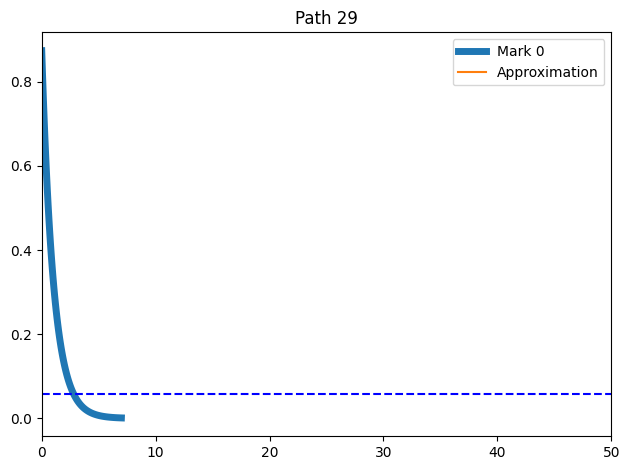

In [ ]:

time_intensities = data['train'][0]['target_kernel_grids']
intensities = data['train'][0]['target_kernel_evaluations']
interpolator =FuncInterpolator(data['train'][0]['target_kernel_grids'].unsqueeze(0), data['train'][0]['target_kernel_evaluations'], mode="interpolate", out_of_bounds_value=0)
sample_times = torch.linspace(data['train'][0]['target_kernel_grids'].min(), data['train'][0]['target_kernel_grids'].max()*50, 2000).unsqueeze(0)
approx = interpolator(sample_times.unsqueeze(0))
c = ['blue', 'orange', 'green']
for mark in range(marks):
    plt.plot(time_intensities[mark], intensities[mark], label=f'Mark {mark}', linewidth=5)
    plt.plot(sample_times.squeeze(), approx.squeeze(), label=f'Approximation')
    plt.axhline(data['train'][0]['target_base_intensities'][mark], color=c[mark], linestyle='--')

plt.title(f'Path {i}')
plt.legend()
plt.xlim(0, 50)

plt.tight_layout()
plt.show()


In [ ]:
approx.min()